## <center>eXtreme Gradient Boosting (XGBoost)</center>
<center>By Monir Zaman (Md Moniruzzaman), mmoniruz At ucalgary Dot com</center>

XGBoost [1] is a popular machine learning library that is being widely used to solve data science problems. It uses Gradient Boosting framework to implement a machine learning algorithm. It offers both classification and regression. Here, I apply XGBoost on a Social network dataset to infer the day of the week information. I also compare the performance of the XGBoost with Logistic Regression.

#### XGBoost Installation
Installing Xgboost on Windows is slightly complicated. I had success by following the first answer from user Vu Anh on the QA thread [3]. 


#### Dataset
In recent social network applications, a user can disclose their location to other users by posting a status update. This feature is also known as check-in and the social networks that support this feature are known as geo-social networks (GSNs). We use a GSN dataset that is collected from Gowalla [2]. Dataset presented here is preprocessed. The preprocessed version is made available here [4].

In [1]:
#Loading dataset
import os
import pandas as pd
import numpy as np

dr='C:\\Users\\Van\\Google Drive\\rWorkspace\\data\\gowallaBrightkite'
runFromLab=True
if runFromLab:
    dr='C:\\Users\\mmoniruz\\Documents\\systemfiles_Data' #lab
    
dfFileIn=os.path.join(dr,'GowallaInCSV_3.csv')
#end of global parameter settings


df=pd.read_csv(dfFileIn)

'''In data preprocessing, we subtract ith check-in date from (i+1)th check-in date. 
This process might introduce negative daysSince value for a few records across users. 
We remove those records'''

df=df[df['daysSince']>=0]
df.reset_index(inplace=True)
print 'First few records\n',df.head()

First few records
   index             datetime  id        lat       long      loc  \
0      0  2010-05-22 02:49:04   0  30.248924 -97.749626   608105   
1      1  2010-05-22 17:50:55   0  39.297443 -94.716053     8977   
2      2  2010-05-22 19:13:12   0  38.985246 -94.605919    18574   
3      3  2010-05-23 16:50:50   0  39.093533 -94.593174    17269   
4      4  2010-05-23 17:51:57   0  39.093258 -94.593871  1161876   

                  timeDelays        wd  daysSince  td_total_secs  \
0  0 days 15:01:51.000000000  Saturday          0          54111   
1  0 days 01:22:17.000000000  Saturday          0           4937   
2  0 days 21:37:38.000000000  Saturday          0          77858   
3  0 days 01:01:07.000000000    Sunday          0           3667   
4  0 days 04:48:48.000000000    Sunday          0          17328   

     disFromMFLoc  disFromPrevLoc      ctime        ss        rf  
0     2242.514992        0.000000  LateNight  0.024390  0.004444  
1  1040582.790390  1042758.724

#### Overview of the dataset

In [2]:
xdf=df[:10000]      #taking subset of the dataframe for this experiment
print 'xdf dimensions ',xdf.shape
print 'xdf summary\n',xdf.describe()

xdf dimensions  (10000, 15)
xdf summary
              index            id           lat          long            loc  \
count  10000.000000  10000.000000  10000.000000  10000.000000    10000.00000   
mean    5017.218400     21.762800     35.906369   -100.166665   386377.36600   
std     2899.823203     15.487825      4.902153     19.436753   620940.77939   
min        0.000000      0.000000    -34.119453   -159.498158     8904.00000   
25%     2501.750000      4.000000     33.077400   -118.419792    34087.00000   
50%     5017.500000     22.000000     35.133158    -97.744675   147717.00000   
75%     7529.250000     35.000000     39.953448    -89.895501   502092.00000   
max    10042.000000     53.000000     60.193511     18.480019  5778967.00000   

          daysSince    td_total_secs     disFromMFLoc   disFromPrevLoc  \
count  10000.000000     10000.000000     10000.000000     10000.000000   
mean       0.653100     73496.773800    442435.894900     58833.262988   
std        6.2324

#### Analysis question
Given a check-in record, can we tell what day of the week it is? Goal is to infer day of the week using other fields as input.

#### Features
- Distance from home ($disFromMFLoc$): defines the distance of a check-in location from the most frequently visited location by the user. 

- Distance from the previous location ($disFromPrevLoc$): defines the distance between user's current location and the location of their immediate previous check-in.

- Social score ($ss$): A location is assigned a social score from a user's perspective by measuring how many of the user's friends have visited the location normalized by the total number of the friends. 

- Relative frequency of a location ($rf$): defines the frequency with which user visits the location relative to all the locations.

- Time interval ($daysSince$): denotes the time interval as described between two consecutive check-ins calculated in days.

- td_total_secs: denotes the time interval as described between two consecutive check-ins calculated in seconds.

- Day of week ($wd$): $wd$ denotes the day of week of the date when the check-in.

- Time of day ($ctime$): denotes the semantic time when the user checked-in. We convert the exact time of day to semantic time such as Morning, Afternoon, Evening, etc.

Other features that are not used in the inference:
- id - user id
- lat - latitude
- long - longitude
- loc - location id
- datetime - date and time of the check-in 
- index - row index
- timeDelays - difference in time delta object between two consecutive check-in dates.

#### Categorical feature
Feature with text value such as day of the week and time of the day needs to be converted into numeric values. Some helper methods are defined here to factor categorical feature as well as to separate dataset into train and test set.
Note that feature scaling is not necessary for XGBoost.

In [17]:
from sklearn.cross_validation import train_test_split
from sklearn import linear_model

#Unique values for categorical features
weekdays=['Friday','Saturday','Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday']
ctime_label=["Morning","Afternoon","Evening","LateNight"]

def factorFeatureFromLabels(adf, featureName, FactorLabel):
    '''Factorize the categorical feature featureName
    from a predefined factored labels; add a new column in place;
        Args:
            adf: contains data to factor
            featureName: is the column name of adf to be factored
            FactorLabel: is a list of strings containing distinct values of featureName. 
            Use index of the string as the new value.
        Returns:
            None
    '''
    #prepare a dictionary of value and their corresponding index
    fac_indx=dict()
    for i,afac in enumerate(FactorLabel):
        fac_indx[afac]=i
    
    #adding a new column with the numeric value
    suffix='_fac'
    nar=adf[featureName].apply(lambda x:fac_indx[x])
    adf[featureName+suffix]=nar
    
    #testing
    aindx=adf.index[0]
    assert fac_indx[adf.ix[aindx][featureName]]==adf.ix[aindx][featureName+suffix]
    #end of testing

def divide_train_test(mdf, out_feature,testSize=.2):
    '''Dividing dataframe to train and test set
        Args:
            mdf: dataframe
            out_feature: column that is also the outcome variable
            testSize: ratio of the test size in the scale [0,1]
        Returns:
            Trainset, label for the trainset, Testset and label for the test set
    '''
    temp=mdf.copy(deep=True)      #for testing purpose
    
    #separate the outcome variable
    y = mdf.pop(out_feature)
    X = mdf
    X_train,X_test,y_train,y_test = train_test_split(X.index,y,test_size=testSize)

    train=mdf.iloc[X_train]
    test=mdf.iloc[X_test]
        
    assert list(temp.ix[X_train[:5]][out_feature])==list(y_train.ix[X_train[:5]])
        
    return train, y_train, test, y_test    

In [4]:
#Factor categorical feature
factorFeatureFromLabels(xdf, 'wd',weekdays)   #factored feature will be addes wd_fac
factorFeatureFromLabels(xdf, 'ctime', ctime_label)   #factored feature will be addes ctime_fac

#Divide dataframe to train and test dataset
train, y_train, test, y_test=divide_train_test(xdf,'wd_fac')   #pass dataset, output feature name

#drop the original wd and ctime column since we have added wd_fac, ctime_fac
#also, drop unnecessary columns such as datetime, index, user id, latitude, longitude, etc.
dropCol=[u'datetime','index', u'id', u'lat', u'long', u'loc', u'timeDelays','wd','ctime']
train.drop(dropCol,axis=1,inplace=True)
test.drop(dropCol,axis=1,inplace=True)

C:\Users\mmoniruz\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\mmoniruz\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\mmoniruz\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Grid search to find optimal parameter value
I will apply Grid search to find optimized value of the following parameters:
<ul>
<li>Number of boosting iterations (num_boost_round)</li>
<li>Learning rate (eta)</li>
<li>Ratio of dataset that are chosen as random samples for each tree(Subsample)</li>
</ul>

In [6]:
import xgboost as xgb
from sklearn.grid_search import GridSearchCV

xgdmat = xgb.DMatrix(train, y_train)

our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': "multi:softmax", 'num_class':7, 'max_depth':3, 'min_child_weight':1,
             "eval_metric" : "mlogloss"
             } 

#Perform grid search for optimized settings
cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 3100, 
                nfold = 5, early_stopping_rounds = 100) 

Will train until cv error hasn't decreased in 100 rounds.
Stopping. Best iteration: 429


Accuracy score (num_boost_round=429) 0.3785


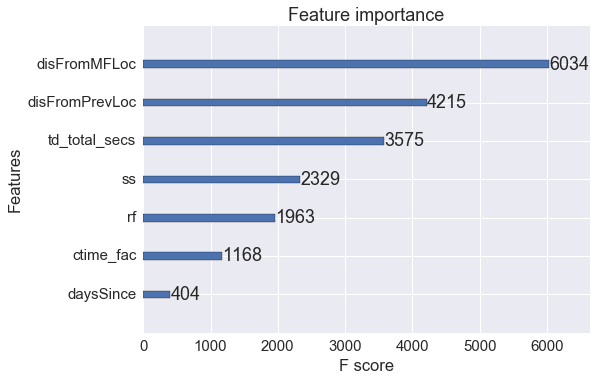

In [7]:
#Now setting the num_boost_round to value found from the above search
bestRound=429
final_gb = xgb.train(our_params, xgdmat, num_boost_round = bestRound)

#printing out the importance of features based on training set
%matplotlib inline
import seaborn as sns
sns.set(font_scale = 1.5)
xgb.plot_importance(final_gb)

#testing
testdmat = xgb.DMatrix(test)

from sklearn.metrics import accuracy_score
y_pred = final_gb.predict(testdmat) # Predict using our testdmat

print "Accuracy score (num_boost_round=429)",accuracy_score(y_pred,y_test)

Grid search will be used to find optimal value for learning rate and subsample. 

In [8]:
#next perform grid search on the learning rate and subsample
def grid_search(cv_params, ind_params,train_rec, train_label):
    fitted_gs = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1) 
    fitted_gs.fit(train_rec, train_label)
    return fitted_gs

cv_params = {'learning_rate': [0.1, 0.01], 'subsample': [0.7,0.8,0.9]}
ind_params = {'n_estimators': 1000, 'seed':0, 'colsample_bytree': 0.8, 
             'objective': "multi:softmax",'max_depth':5,'min_child_weight':1}

gs=grid_search(cv_params,ind_params,train,y_train)
gs.grid_scores_

[mean: 0.39625, std: 0.00898, params: {'subsample': 0.7, 'learning_rate': 0.1},
 mean: 0.39625, std: 0.00819, params: {'subsample': 0.8, 'learning_rate': 0.1},
 mean: 0.39475, std: 0.00760, params: {'subsample': 0.9, 'learning_rate': 0.1},
 mean: 0.38338, std: 0.00882, params: {'subsample': 0.7, 'learning_rate': 0.01},
 mean: 0.38300, std: 0.00887, params: {'subsample': 0.8, 'learning_rate': 0.01},
 mean: 0.38375, std: 0.01118, params: {'subsample': 0.9, 'learning_rate': 0.01}]

In [10]:
#finalize parameters
ind_params = {'n_estimators': 1000, 'seed':0, 'colsample_bytree': 0.8, 
             'objective': "multi:softmax",'num_class':7, "eval_metric" : "mlogloss", 
              'max_depth':5,'min_child_weight':1, 'learning_rate':.1, 'subsample':.8 }
#change objective to 'multi:softprob' for return probabilities

#fitting a tree
gbt = xgb.train(ind_params, xgdmat, num_boost_round = bestRound)


#testing 
y_pred = gbt.predict(testdmat) # Predict using our testdmat
#print testdmat.num_row(), len(y_test)

print "Accuracy score ",accuracy_score(y_pred,y_test)

#calculate training error
y_pred = gbt.predict(xgdmat) # Predict using our testdmat
#print testdmat.num_row(), len(y_test)

print "Training accuracy score ",accuracy_score(y_pred,y_train)

Accuracy score  0.3995
Training accuracy score  0.88475


We can see that second grid search improves accuracy 37.8% from to 39.9%.

#### Compare XGBoost's performance with Logistic regression

In [19]:
from sklearn.metrics import accuracy_score
pd.options.mode.chained_assignment = None

def fit_and_predict(df1,df1_label,df2, df2_label):
    '''Return accuracy calculated by Logistic regression
        Args:
            df1: trainset
            df1_label: trainset label
            df2: testset
            df2_label: testset label
        Returns:
            
    '''
    lgr =linear_model.LogisticRegression(C=1e5)
    lgr.fit(df1,df1_label)

    lgr_pred=lgr.predict(df2)

    return accuracy_score(lgr_pred, df2_label)

def wrap_prediction(adf, output_feature, dropCol):
    '''Accepts a dataframe, divide it into a train set, test set and 
        perform prediction on the output feature. Output feature name comes  
        without suffix. Method by default factors wd, ctime and assumes that distinct 
        feature values: weekdays, ctime_label exists
        Args:
            adf: dataset as a dataframe
            output_feature: column of the outcome variable/feature
            drop_col: list of columns that are not used in the inference
        Returns:
            Accuracy of the logistic regression model on the test set as well as 
            on the train set.
        
    '''

    adf=adf.copy(deep=True)
    adf=adf[adf['daysSince']>=0]
    adf.reset_index(inplace=True)
    
    #Factor categorical feature
    factorFeatureFromLabels(adf, 'wd',weekdays)   #factored feature will be addes wd_fac
    factorFeatureFromLabels(adf, 'ctime', ctime_label)   #factored feature will be addes ctime_fac

    #divide to train and test dataset
    train, y_train, test, y_test=divide_train_test(adf,output_feature)   #pass dataset, output feature name
                                                                         #output feature name will have _fac suffix

    #drop the original wd and ctime column along with other additional columns
    #dropCol list will be taken as input
    train.drop(dropCol,axis=1,inplace=True)
    test.drop(dropCol,axis=1,inplace=True)

    #fit a logistic regression model
    from sklearn import linear_model
    lgr =linear_model.LogisticRegression(C=1e5)
    lgr.fit(train,y_train)

    # perform inference
    lgr_pred=lgr.predict(test)
    
    return dict({'Accuracy score ':accuracy_score(lgr_pred, y_test),
                 'Training accuracy score ':fit_and_predict(train,y_train, train, y_train)})


adf=df[:nrec]
dropCol=[u'datetime','index', u'id', u'lat', u'long', u'loc', u'timeDelays','wd','ctime']
acc_logit=wrap_prediction(adf,'wd_fac',dropCol)

print 'Logistic Regression:'
for acc_t,acc in acc_logit.iteritems():
    print '{0}:{1}'.format(acc_t,acc) 

Logistic Regression:
Accuracy score :0.207
Training accuracy score :0.206125


Xgboost (39.9%) performs twice as much better than Logistic regression (20.7%)

#### Reference:
1. T. Chen and Tong He. xgboost: eXtreme Gradient Boosting. R package version 0.4-2 (2015).
2. E. Cho, S. A. Myers, J. Leskovec. Friendship and Mobility: Friendship and Mobility: User Movement in Location-Based Social Networks ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD), 2011.
3. Xgboost Installation: http://stackoverflow.com/questions/33749735/how-to-install-xgboost-package-in-python-windows-platform
4. Gowalla preprocessed dataset: https://drive.google.com/drive/folders/0B28H8IpKzp1KdzRRdmYtYnNhNzA